In [8]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from selenium.webdriver.chrome.options import Options
import time

In [3]:
from urllib.request import urlopen
from bs4 import BeautifulSoup as soup
from PIL import Image
import pandas as pd
import os
import requests

C:\Users\Filbert Patricio\AppData\Local\Temp\ipykernel_4844\3421063386.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
url = "https://www.taste.com.au/recipes/collections"

In [ ]:

url = "https://www.taste.com.au/recipes/creamy-chickpea-cucumber-salad/894b2490-00e7-45c7-9571-4ada5c942518?r=recipes/cucumberrecipes&c=ygfz2g53/Cucumber%20recipes"
response = urlopen(url)

object = soup(response.read())
# response.close()
# Food name
foodname = object.find('h1').get_text().strip()

find_serving = object.find('ul',{'class':'recipe-cooking-info'}).find_all('span')
# Serving size
serving = find_serving[1].get_text().strip()

image = object.find('figure',{'class':'lead-image-block'}).find('img').attrs['src']





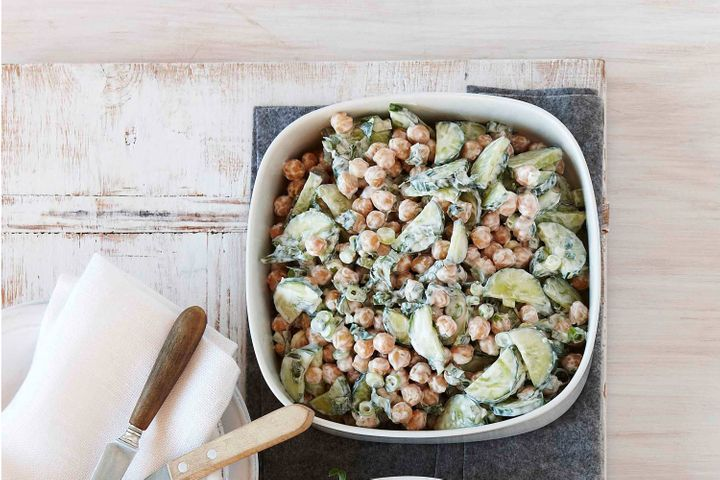

In [46]:
img = Image.open(urlopen(image))
display(img)

In [ ]:
# <div class="col-sm-4 recipe-section recipe-ingredients-section">
#     <h4 class="visible-print-block">Ingredients (6)</h4>
    
# <div class="section-title recipe-ingredients-title hidden-print">
#     <h2>Ingredients <span class="count">(6)</span></h2>
# </div>
    
#     <ul>
#                                                 <li>
#                     <div class="ingredient-description" data-raw-ingredient="2 x 400g cans chickpeas, rinsed and drained">
#                                                     2 x 400g cans chickpeas, rinsed and drained
#                                                                     </div>
#                 </li>
#                             <li>
#                     <div class="ingredient-description" data-raw-ingredient="2 lebanese cucumbers, halved and sliced">
#                                                     2 Lebanese cucumbers, halved and sliced
#                                                                     </div>
#                 </li>
#                             <li>
#                     <div class="ingredient-description" data-raw-ingredient="4 spring onions, sliced">
#                                                     4 spring onions, sliced
#                                                                     </div>
#                 </li>
#                             <li>
#                     <div class="ingredient-description" data-raw-ingredient="1/2 cup mint leaves, chopped">
#                                                     1/2 cup mint leaves, chopped
#                                                                     </div>
#                 </li>
#                             <li>
#                     <div class="ingredient-description" data-raw-ingredient="1/2 cup greek style plain yoghurt">
#                                                     1/2 cup Greek style plain yoghurt
#                                                                     </div>
#                 </li>
#                             <li>
#                     <div class="ingredient-description" data-raw-ingredient="1 small garlic clove, crushed">
#                                                     1 small garlic clove, crushed
#                                                                     </div>
#                 </li>
#                         </ul>
#     <div class="ingredient-action-buttons">
                
# <div class="allergies-and-nutrition-container">
#                 <div class="allergens">
#         <span class="icon info"></span>
#         <div class="print-icon info">
#             <img src="/assets/static/icons/info.svg" alt="info">
#         </div>
#         <div class="allergens-tags"><span>Allergens</span> Recipe may contain                    milk                    and lactose.
#             </div>    </div>
#                 <div class="view-nutritional-info-container">
#             <a href="javascript:void(0)" class="view-nutritional-info">Nutrition info</a>
#         </div>
#     </div>
#     </div>
#     <div class="visible-xs-block ad-border">
        
#     </div>
# </div>

In [47]:
# Ingredients
ingredientlist = []

for li in object.find('div',{'class':'col-sm-4 recipe-section recipe-ingredients-section'}).find('ul').findAll('li'):
    ingredient = li.find('div').get_text().strip()
    ingredientlist.append(ingredient)

print(ingredientlist)

['2 x 400g cans chickpeas, rinsed and drained', '2 Lebanese cucumbers, halved and sliced', '4 spring onions, sliced', '1/2 cup mint leaves, chopped', '1/2 cup Greek style plain yoghurt', '1 small garlic clove, crushed']


In [ ]:
# <div class="nutrition-info-container"><div class="title"><h3>Nutrition per serving</h3> <span class="subscript">% Daily Value#</span></div> <div class="nutrition-container"><table class="table"><tr class="energy"><td class="name energy">Energy</td> <td class="value">630 kj (151cal)</td> <td class="perc">7%</td></tr><tr class="protein"><td class="name protein">Protein</td> <td class="value">8.5g</td> <td class="perc">17%</td></tr><tr class="fatTotal"><td class="name fatTotal">Total Fat</td> <td class="value">3.5g</td> <td class="perc">5%</td></tr><tr class="fatSaturated"><td class="name fatSaturated indented-2">Saturated</td> <td class="value">0.7g</td> <td class="perc">3%</td></tr><!----><tr class="carbTotal"><td class="name carbTotal">Carbohydrate Total</td> <td class="value">22.8g</td> <td class="perc">7%</td></tr><tr class="carbSugars"><td class="name carbSugars indented-2">Sugars</td> <td class="value">5.3g</td> <td class="perc">6%</td></tr><tr class="dietaryFibre"><td class="name dietaryFibre">Dietary Fiber</td> <td class="value">6.1g</td> <td class="perc">20%</td></tr><tr class="sodium"><td class="name sodium">Sodium</td> <td class="value">218.3mg</td> <td class="perc">9%</td></tr><tr class="calcium"><td class="name calcium">Calcium</td> <td class="value">79.9mg</td> <td class="perc">10%</td></tr><tr class="magnesium"><td class="name magnesium">Magnesium</td> <td class="value">34.5mg</td> <td class="perc">11%</td></tr><tr class="potassium"><td class="name potassium">Potassium</td> <td class="value">249.7mg</td> <td class="perc">-</td></tr><tr class="iron"><td class="name iron">Iron</td> <td class="value">1.3mg</td> <td class="perc">11%</td></tr><tr class="zinc"><td class="name zinc">Zinc</td> <td class="value">1mg</td> <td class="perc">8%</td></tr><tr class="phosphorus"><td class="name phosphorus">Phosphorus</td> <td class="value">117.9mg</td> <td class="perc">12%</td></tr><tr class="vitaminA"><td class="name vitaminA">Vitamin A</td> <td class="value">79.1μg</td> <td class="perc">11%</td></tr><tr class="vitaminC"><td class="name vitaminC">Vitamin C</td> <td class="value">4.1mg</td> <td class="perc">10%</td></tr><!----><!----><!----><!----><tr class="folicAcidB9"><td class="name folicAcidB9">Folic Acid B9</td> <td class="value">53.8</td> <td class="perc">27%</td></tr><tr class="vitaminB12"><td class="name vitaminB12">Vitamin B12</td> <td class="value">0.2μg</td> <td class="perc">10%</td></tr><!----><!----><tr class="vitaminK"><td class="name vitaminK">Vitamin K</td> <td class="value">31μg</td> <td class="perc">39%</td></tr></table></div> <div class="footer"><p>Nutrition information and health score does not include ingredients listed as to serve or any
#                     serving suggestions.</p> <p>Nutrition information is calculated using an ingredient database and should be considered an
#                     estimate.</p> <p># The % daily Values indicates how much of a nutrient in a food serving contributes to a daily
#                     diet, based on general nutritional advice for a diet of 2100 calories a day.</p></div></div>

In [ ]:

def get_food_data_by_url(url,data,driver=None):
    if driver is None:
        driver = webdriver.Chrome()
    
    driver.get(url)

    time.sleep(2)
    foodname = driver.find_element(By.CLASS_NAME,'recipe-title-container').find_element(By.TAG_NAME,'h1').get_attribute('innerHTML').strip()
    serving = driver.find_element(By.CLASS_NAME,'recipe-cooking-info').find_element(By.TAG_NAME,'span').get_attribute('innerHTML').strip()
    image = driver.find_element(By.CLASS_NAME,'lead-image-block').find_element(By.TAG_NAME,'img').get_attribute('src')

    response = urlopen(url)
    object = soup(response.read())



    find_serving = object.find('ul',{'class':'recipe-cooking-info'}).find_all('span')
    # Serving size
    if len(serving) == 2:
        serving = serving[1].get_text().strip()
    else:
        serving = serving[2].get_text().strip()

    # image = object.find('figure',{'class':'lead-image-block'}).find('img').attrs['src']



    button = driver.find_element(By.CLASS_NAME,'view-nutritional-info')
    button.click()
    time.sleep(2)

    calories = driver.find_element(By.CLASS_NAME,'energy').find_element(By.CLASS_NAME,'value').get_attribute('innerHTML').strip()
    protein = driver.find_element(By.CLASS_NAME,'protein').find_element(By.CLASS_NAME,'value').get_attribute('innerHTML').strip()
    fat = driver.find_element(By.CLASS_NAME,'fatTotal').find_element(By.CLASS_NAME,'value').get_attribute('innerHTML').strip()
    carb = driver.find_element(By.CLASS_NAME,'carbTotal').find_element(By.CLASS_NAME,'value').get_attribute('innerHTML').strip()
    sodium = driver.find_element(By.CLASS_NAME,'sodium').find_element(By.CLASS_NAME,'value').get_attribute('innerHTML').strip()
    fibre = driver.find_element(By.CLASS_NAME,'dietaryFibre').find_element(By.CLASS_NAME,'value').get_attribute('innerHTML').strip()

    food = {'foodname':foodname,'serving':serving,'image':image,'calories':calories,'protein':protein,'fat':fat,'carb':carb,'sodium':sodium,'fibre':fibre}

    data.append(food)

    driver.quit()
    return data




In [116]:
foodlist = []

links = ["https://www.taste.com.au/recipes/cos-salad-creamy-tarragon-dressing/94d0c7a1-b210-4680-b733-2a596421f99b?utm_source=recipe&utm_campaign=healthier_scenarioA",
         "https://www.taste.com.au/recipes/creamy-chickpea-cucumber-salad/894b2490-00e7-45c7-9571-4ada5c942518?r=recipes/cucumberrecipes&c=ygfz2g53/Cucumber%20recipes"]

for link in links:
    foodlist = get_food_data_by_url(link,foodlist)


dataframe = pd.DataFrame(foodlist)
dataframe.head(3)

,foodname,serving,image,calories,protein,fat,carb,sodium,fibre
0,Cos salad with creamy tarragon dressing,25m,,"<div class=""name energy"">Energy</div> <div cla...","<div class=""name protein"">Protein</div> <div c...","<div class=""name fatTotal"">Total Fat</div> <di...","<div class=""name carbTotal"">Carbohydrate Total...","<div class=""name sodium"">Sodium</div> <div cla...","<td class=""name dietaryFibre"">Dietary Fiber</t..."
1,Creamy chickpea and cucumber salad,15m,,"<div class=""name energy"">Energy</div> <div cla...","<div class=""name protein"">Protein</div> <div c...","<div class=""name fatTotal"">Total Fat</div> <di...","<div class=""name carbTotal"">Carbohydrate Total...","<div class=""name sodium"">Sodium</div> <div cla...","<td class=""name dietaryFibre"">Dietary Fiber</t..."


In [ ]:
from selenium.webdriver import ChromeOptions
proxy = "123.123.123.123:8080"  # Replace with a valid proxy
chrome_options = ChromeOptions()
chrome_options.add_argument(f'--proxy-server=http://{proxy}')
driver = webdriver.Chrome(options=chrome_options)


In [ ]:
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
# from selenium.webdriver.common.by import By

# WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'nutrition-info-container')))


In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.expected_conditions import element_to_be_clickable

def get_food_data_by_url(url, data, driver=None):
    # Reuse WebDriver if provided, otherwise initialize a new instance
    if driver is None:
        driver = webdriver.Chrome()
        manage_driver = True  # Flag to quit driver later
    else:
        manage_driver = False
    
    driver.get(url)

    # Helper function for safe element retrieval
    def get_element_text(by, value, parent=None):
        try:
            element = (parent or driver).find_element(by, value)
            return element.get_attribute('innerHTML').strip()
        except NoSuchElementException:
            return None

    def wait_for_element(by, value, timeout=10):
        try:
            return WebDriverWait(driver, timeout).until(EC.presence_of_element_located((by, value)))
        except TimeoutException:
            return None

    try:
        # Food name
        foodname = get_element_text(By.CLASS_NAME, 'recipe-title-container h1')

        # Serving size
        find_serving = driver.find_element(By.CLASS_NAME, 'recipe-cooking-info').find_elements(By.TAG_NAME, 'li')
        # Serving size
        if len(find_serving) < 3:
            serving = find_serving[1].find_element(By.TAG_NAME, 'span').get_attribute('innerHTML').strip()
        else:
            serving = find_serving[2].find_element(By.TAG_NAME, 'span').get_attribute('innerHTML').strip()

        # Image URL
        image = driver.find_element(By.CLASS_NAME, 'lead-image-block').find_element(By.TAG_NAME, 'img').get_attribute('src')

        # Check if there is nutritional button
        button = wait_for_element(By.CLASS_NAME, 'view-nutritional-info')
       
        if button is None:
            print(f"No nutritional button found for {url}")
            return data
        else:
            # Scroll into view and click
            driver.execute_script("arguments[0].scrollIntoView(true);", button)
            try:
                # Wait until button is clickable
                button = driver.find_element(By.CLASS_NAME,'show-details').find_element(By.CLASS_NAME,'view-nutritional-info')
                button.click()

                # clickable_button = WebDriverWait(driver, 10).until(element_to_be_clickable((By.CLASS_NAME, 'view-nutritional-info')))
                # # Use ActionChains for clicking
                # ActionChains(driver).move_to_element(clickable_button).click().perform()
                time.sleep(2)
            except Exception as e:
                print(f"Error clicking nutritional button: {e}")
                return data

        # Wait for nutritional sidebar to load
        wait_for_element(By.CLASS_NAME, 'nutrition-info-container')

        # Nutritional data
        nutrition_data = {}
        for key in ['energy', 'protein', 'fatTotal', 'carbTotal', 'sodium', 'dietaryFibre']:
            try:
                value_element = driver.find_element(By.CLASS_NAME, key).find_element(By.CLASS_NAME, 'value')
                nutrition_data[key] = value_element.get_attribute('innerHTML').strip()
            except NoSuchElementException:
                nutrition_data[key] = None  # Handle missing data gracefully

        # Build food dictionary
        food = {
            'foodname': foodname,
            'serving': serving,
            'image': image,
            'calories': nutrition_data.get('energy'),
            'protein': nutrition_data.get('protein'),
            'fat': nutrition_data.get('fatTotal'),
            'carb': nutrition_data.get('carbTotal'),
            'sodium': nutrition_data.get('sodium'),
            'fibre': nutrition_data.get('dietaryFibre'),
        }

        data.append(food)

    except Exception as e:
        print(f"An error occurred while processing {url}: {e}")
        return data
    finally:
        # Close the driver only if it was created in this function
        if manage_driver:
            driver.quit()
        return data

    return data


In [42]:
data = []


# urls = ["https://www.taste.com.au/recipes/rockmelon-cucumber-ice-blocks/Pz7npfv7?r=recipes/cucumberrecipes&c=ygfz2g53/Cucumber%20recipes"]

# Initialize WebDriver once
# driver = webdriver.Chrome()
options = Options()
driver = webdriver.Chrome(options=options)

# Inject headers using Chrome DevTools Protocol
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36',
    'Referer': 'https://www.google.com/',
    'Accept-Language': 'en-US,en;q=0.9',
}
driver.execute_cdp_cmd('Network.setExtraHTTPHeaders', {'headers': headers})

for url in urls:
    data = get_food_data_by_url(url, data, driver)
    time.sleep(2)

# Quit driver after processing all URLs
driver.quit()

dataframe = pd.DataFrame(data)


An error occurred while processing https://www.taste.com.au/recipes/unique-fried-rice-recipe/ul4qta63#coral_thread: Message: element click intercepted: Element <a href="javascript:void(0)" class="view-nutritional-info">...</a> is not clickable at point (128, 8). Other element would receive the click: <div class="logo-and-user-controls">...</div>
  (Session info: chrome=131.0.6778.86)
Stacktrace:
	GetHandleVerifier [0x00007FF77FEE6CF5+28821]
	(No symbol) [0x00007FF77FE53880]
	(No symbol) [0x00007FF77FCF578A]
	(No symbol) [0x00007FF77FD50E8E]
	(No symbol) [0x00007FF77FD4E92C]
	(No symbol) [0x00007FF77FD4BAF6]
	(No symbol) [0x00007FF77FD4AA51]
	(No symbol) [0x00007FF77FD3CBA0]
	(No symbol) [0x00007FF77FD6F2FA]
	(No symbol) [0x00007FF77FD3C3F6]
	(No symbol) [0x00007FF77FD6F510]
	(No symbol) [0x00007FF77FD8F412]
	(No symbol) [0x00007FF77FD6F0A3]
	(No symbol) [0x00007FF77FD3A778]
	(No symbol) [0x00007FF77FD3B8E1]
	GetHandleVerifier [0x00007FF78021FCED+3408013]
	GetHandleVerifier [0x00007FF78

KeyboardInterrupt: 

In [86]:
dataframe.head(5)

NameError: name 'dataframe' is not defined

In [28]:
def crawl_url(url, urls, driver=None, depth=1):
    # Reuse WebDriver if provided, otherwise initialize a new instance
    if driver is None:
        options = Options()
        options.add_argument("--disable-blink-features")
        options.add_argument("--disable-blink-features=AutomationControlled")

        options.add_experimental_option("excludeSwitches", ["enable-automation"])
        options.add_experimental_option('useAutomationExtension', False)
        driver = webdriver.Chrome(options=options)
        manage_driver = True  # Flag to quit driver later
    else:
        manage_driver = False

    try:
        # Initialize the queue with the root URL
        queue = [url]
        print(f"Starting crawl with root URL: {url}")


        while queue and depth > 0:
            current_url = queue.pop(0)  # Get the next URL from the queue
            print(f"Accessing URL: {current_url}")
            
            try:
                driver.get(current_url)
                wait = WebDriverWait(driver, 10)  # 10-second timeout

                # Locate the recommendations container
                print("Waiting for recommendations container...")
                section = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'recommendations-container')))
                print("Recommendations container located.")

                # Collect all links on the current page
                print("Locating carousel items...")
                links = section.find_element(By.CLASS_NAME, 'flex-carousel') \
                    .find_element(By.CLASS_NAME, 'carousel-container') \
                    .find_element(By.TAG_NAME, 'div') \
                    .find_elements(By.CLASS_NAME, 'carousel-item')

                if not links:
                    print(f"No carousel items found for: {current_url}")
                    continue

                for link in links:
                    try:
                        href = link.find_element(By.CLASS_NAME, 'card-body') \
                            .find_element(By.TAG_NAME, 'a').get_attribute('href')
                        if href and href not in urls:  # Avoid duplicates
                            print(f"Link found: {href}" + "Number of Links Collected: " + str(len(urls))) 
                            urls.append(href)
                            queue.append(href)  # Add new link to the queue
                            
                           

                    except Exception as e:
                        print(f"Error retrieving link from {current_url}: {e}")
                        continue

            except Exception as e:
                print(f"Error accessing {current_url}: {e}")

            
            while len(queue) > 0:
             current_queue = queue.pop(0)
             if depth > 1:
                # Recursively crawl the link
                time.sleep(3)
                crawl_url(current_queue, urls, driver, depth-1)

    except Exception as e:
        print(f"An error occurred during crawling: {e}")

    finally:
        # Close the driver only if it was created in this function
        if manage_driver:
            driver.quit()


In [ ]:
# url = "https://www.taste.com.au/recipes/mexican-style-prawns-rice-recipe/a52cufij?r=dinner/rrzebwl2"

# # url = "https://www.taste.com.au/recipes/spring-beef-casserole-recipe/5p2v7cxk#coral_thread"
# options = Options()
# options.add_argument("--disable-blink-features")
# options.add_argument("--disable-blink-features=AutomationControlled")

# options.add_experimental_option("excludeSwitches", ["enable-automation"])
# options.add_experimental_option('useAutomationExtension', False)
# driver = webdriver.Chrome(options=options)

# # Inject headers using Chrome DevTools Protocol
# headers = {
#     'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36',
#     'Referer': 'https://www.google.com/',
#     'Accept-Language': 'en-US,en;q=0.9',
# }
# driver.execute_cdp_cmd('Network.setExtraHTTPHeaders', {'headers': headers})


# # Crawl the URL
# crawl_url(url, urls, driver,3)

# driver.quit()



Starting crawl with root URL: https://www.taste.com.au/recipes/mexican-style-prawns-rice-recipe/a52cufij?r=dinner/rrzebwl2
Accessing URL: https://www.taste.com.au/recipes/mexican-style-prawns-rice-recipe/a52cufij?r=dinner/rrzebwl2
Waiting for recommendations container...
Recommendations container located.
Locating carousel items...
Link found: https://www.taste.com.au/recipes/honey-mustard-pork-caraway-coleslaw/e4418bae-1db9-46a1-98e8-a5ea1ec8a3af#coral_threadNumber of Links Collected: 1105
Link found: https://www.taste.com.au/recipes/watermelon-guava-lime-slushy/f2d0cbe5-0aca-436e-b50b-76641354d4d0#coral_threadNumber of Links Collected: 1106
Link found: https://www.taste.com.au/recipes/chicken-carrot-tagine/fe742451-8218-44b3-9088-813f6cceed74#coral_threadNumber of Links Collected: 1107
Link found: https://www.taste.com.au/recipes/freeze-ahead-mince-mix/5m6uax8b#coral_threadNumber of Links Collected: 1108
Link found: https://www.taste.com.au/recipes/quick-pie-maker-bread-rolls-recipe/

KeyboardInterrupt: 

In [31]:
saved_urls = urls
len(saved_urls)

1095

In [30]:
len(urls)

1095

In [ ]:
# Make a dataframe where column is url
dataframe = {'urls': saved_urls}
dataframe = pd.DataFrame(dataframe)
dataframe.head(5)

,urls
0,https://www.taste.com.au/recipes/unique-fried-...
1,https://www.taste.com.au/recipes/cheesy-french...
2,https://www.taste.com.au/recipes/mexican-bento...
3,https://www.taste.com.au/recipes/thai-chicken-...
4,https://www.taste.com.au/recipes/oven-baked-mu...


In [35]:
# Save to csv
dataframe.to_csv('urltaste.csv')

In [147]:
url_no =431

In [149]:
def create_driver():
    options = Options()
    options.add_argument("--disable-blink-features")
    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_experimental_option("excludeSwitches", ["enable-automation"])
    options.add_experimental_option('useAutomationExtension', False)
    driver = webdriver.Chrome(options=options)
    
    # Inject headers using Chrome DevTools Protocol
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36',
        'Referer': 'https://www.google.com/',
        'Accept-Language': 'en-US,en;q=0.9',
    }
    driver.execute_cdp_cmd('Network.setExtraHTTPHeaders', {'headers': headers})
    return driver

In [150]:
driver = create_driver()

dataframe1 = pd.read_csv('E:/Big_Data_Analysis/urltaste.csv')
# dataframe1 = ["https://www.taste.com.au/recipes/unique-fried-rice-recipe/ul4qta63#coral_thread"]

try:
    # Start processing URLs
    for url in dataframe1['urls'][url_no:]:
        try:
            print(f"Processing URL progress: {url_no}/{len(dataframe1['urls'])}")
            data = get_food_data_by_url(url, data, driver)
            time.sleep(2)
            url_no += 1
            
            # Refresh driver after every 40 iterations
            if url_no % 40 == 0:
                print("Refreshing driver after 40 iterations...")
                driver.quit()  # Close the current driver
                driver = create_driver()  # Create a new driver instance

        except Exception as e:
            print(f"An error occurred while processing {url}: {e}")
            break

finally:
    driver.quit()  # Ensure the driver is closed in all cases

Processing URL progress: 431/1095
Processing URL progress: 432/1095
Processing URL progress: 433/1095
An error occurred while processing https://www.taste.com.au/recipes/peppermint-chocolate-hearts/2c8bef63-4027-4e6a-bfc9-b1f5660fdf22#coral_thread: list index out of range
Processing URL progress: 434/1095
Processing URL progress: 435/1095
Processing URL progress: 436/1095
No nutritional button found for https://www.taste.com.au/recipes/triple-choc-favourites-brownie/SRTrSELh#coral_thread
Processing URL progress: 437/1095
Processing URL progress: 438/1095
Processing URL progress: 439/1095
Refreshing driver after 40 iterations...
Processing URL progress: 440/1095
Processing URL progress: 441/1095
Processing URL progress: 442/1095
Processing URL progress: 443/1095
Processing URL progress: 444/1095
Processing URL progress: 445/1095
Processing URL progress: 446/1095
No nutritional button found for https://www.taste.com.au/recipes/pie-maker-sausage-rolls-recipe/puzahpzi#coral_thread
Processi

In [ ]:
# print(url_no)


,foodname,serving,image,calories,protein,fat,carb,sodium,fibre
354,Turmeric and date bliss balls,20,https://img.taste.com.au/P_BW-pEk/w720-h480-cf...,571 kj (136cal),3g,8.5g,11g,5mg,2.7g
355,Lemon and blueberry vegan tart,8,https://content.api.news/v3/images/bin/fc2a5a8...,2574 kj (615cal),10.6g,37.2g,68.5g,34.4mg,7.3g
356,Perfect scones,12,https://img.taste.com.au/U-eYD6dB/w720-h480-cf...,720 kj (172cal),3.4g,5.3g,27.3g,268mg,1g
357,Seared sesame tuna on pickled cucumber salad,6,https://img.taste.com.au/Dnl3Ocuk/w720-h480-cf...,2012 kj (481cal),43.8g,29.6g,10.8g,556.3mg,3.9g
358,Five-spice chicken wings,4,https://img.taste.com.au/8SVCjh4V/w720-h480-cf...,1848 kj (442cal),31.6g,21.0g,27.4g,809.7mg,1.2g
359,Potatoes in red wine,6,https://img.taste.com.au/TkZLF1Pl/w720-h480-cf...,719 kj (172cal),2.8g,None,26.0g,116.1mg,1.9g
360,"Prawn, avocado and lime crostini with rouille",4,https://img.taste.com.au/am9pWkwp/w720-h480-cf...,3406 kj (814cal),16.4g,66.3g,40.4g,741.3mg,5.4g
361,"Pesto, olive and baby rocket blinis",20,https://img.taste.com.au/SGUbAUXZ/w720-h480-cf...,286 kj (68cal),1.3g,4.9g,4.3g,228mg,1.3g
362,Carrot and pineapple daisy cake,20,https://img.taste.com.au/z9kBeZKg/w720-h480-cf...,2115 kj (505cal),7.0g,28.0g,58.9g,332mg,1.2g
363,Orange and balsamic beetroot,4,https://img.taste.com.au/uabyiyAK/w720-h480-cf...,484 kj (116cal),1.2g,4.7g,17.7g,52mg,1.7g


In [151]:
data_saved = data
len(data_saved)
dataframe2 = pd.DataFrame(data_saved)
# dataframe final 10
dataframe2.tail(10)

,foodname,serving,image,calories,protein,fat,carb,sodium,fibre
907,Roast lamb focaccia with tzatziki,4,https://img.taste.com.au/g4cIUm_Y/w720-h480-cf...,5444 kj (1301cal),76.9g,73.4g,83.9g,3.1g,12.7g
908,Choc-peanut pretzel slice,24 pieces,https://img.taste.com.au/aqIcW3Eq/w720-h480-cf...,1388 kj (332cal),5.6g,22g,29.5g,288mg,1.5g
909,Roasted pumpkin and goats cheese pizza,50m,https://img.taste.com.au/bgHHXHau/w720-h480-cf...,1040 kj (249cal),10g,8.5g,33g,None,3g
910,Pancake shaker impossible zucchini slice,15,https://img.taste.com.au/3fAxuUhS/w720-h480-cf...,778 kj (186cal),6.4g,12.9g,11.1g,275.8mg,0.6g
911,Chicken tikka tray bake,45m,https://img.taste.com.au/6sWxQ3i3/w720-h480-cf...,2562 kj (612cal),34.6g,45.6g,15g,None,3.1g
912,Thai beef salad,4,https://img.taste.com.au/N9zB_cHC/w720-h480-cf...,2716 kj (649cal),38.8g,47.8g,16.8g,606.4mg,2.6g
913,Carrot cake,6,https://img.taste.com.au/3eWvBH1R/w720-h480-cf...,2974 kj (711cal),7.5g,35.1g,94.9g,430.2mg,3.1g
914,Gourmet vegetarian pizza,6,https://img.taste.com.au/Tck0p2Ae/w720-h480-cf...,2035 kj (486cal),17.3g,22.0g,55.3g,1.5g,2.5g
915,Macadamia &amp; golden syrup pies,6,https://img.taste.com.au/lHcHAJQe/w720-h480-cf...,4597 kj (1099cal),13.6g,74.4g,101.0g,71mg,5.8g
916,Grilled harissa zucchini on tabbouleh,4,https://img.taste.com.au/0xCrr0Bv/w720-h480-cf...,1021 kj (244cal),9.9g,9.9g,33.8g,221.9mg,7.7g


In [152]:
dataframe2.to_csv('tastescrapedata.csv')